### 텍스트 생성

- **자기 회귀 (autoregressive model)**: 과거 데이터를 바탕으로 미래 데이터를 예측
- **인과 언어 모델 (causal language model)**: 이전 단어들로 다음 단어를 예측

- GPT-2의 텍스트 생성 방식
    $$ P(y_1, \dots, y_t | x) = \prod_{t=1}^{N} P(y_t | y_{<t}, x) $$

    $$ \therefore P(y_1, \dots, y_t | x) = P(y_1 | x) \times P(y_2 | y_1, x) \times P(y_3 | y_1, y_2, x) \times \dots \times P(y_t | y_1, \dots, y_{t-1}, x) $$

    - **해석**:
        - $ P(y_1, \dots, y_t) $: 모든 단어들의 확률, 즉 한 문장에서 각각의 단어가 등장할 확률
        - $ \prod $: 각 단어마다의 확률을 계산하여 곱하는 형태
        - $ y_{<t} = y_1, \dots, y_{t-1} $: 이전 단어들
        - $ P(y_t | y_{<t}, x) $: 조건부 확률 — 입력값 $ x $와 이전 단어들 $ y_1, \dots, y_{t-1} $이 있을 때, $ y_t $의 확률

- 조건부 텍스트 생성 (Conditional Text Generation)
    - $ x $가 주어졌을 때의 텍스트 생성
        - $P(y_t = w_i | y_{<t}, x) = \text{softmax}(z_{t,i}) $ 여기서 $z_{t,i}$ 는 모델의 로짓값
        - $y_t = w_i $: $ i $-번째 예측에서 단어 $ w_i $를 선택할 확률
        - $\hat{y} = \argmax\limits_{y} P(y | x) $: 조건부 확률에 대해 최댓값을 갖는 $ y $를 선택

- 예시: 텍스트 예측 과정
    - $ x = $ "오늘 날씨가 어때?" 의 토큰
        - $P(y_1 = w_1 | x) = y_2 $ → $ \text{argmax}(\text{softmax}(z_1)) = $ "오늘"
        - $P(y_2 = w_2 | y_1, x) = y_3 $ → $ \text{argmax}(\text{softmax}(z_2)) = $ "날씨는"
        - $P(y_3 = w_3 | y_1, y_2, x) = y_4 $ → $ \text{argmax}(\text{softmax}(z_3)) = $ "맑습니다."


### 그리디 서치 디코딩 (Greedy Search Decoding)

- $\hat{y_t} = \argmax\limits_{y_t} P(y_t|y_{<t},x)$
    - 가장 확률이 높은 단어만을 선택

### 그리디 서치 디코딩의 gpt-2 예시

In [1]:
import torch

from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

2024-11-30 09:42:43.116885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732927363.246551     925 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732927363.291096     925 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 09:42:43.650372: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [38]:
import pandas as pd

input_txt = "Surfing is"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [39]:
iterations = []

In [40]:
n_steps = 8
choice_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = {}
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        next_token_logits = output.logits[0,-1,:]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)

        # 가장 확률높은 토큰 저장
        for choice_idx in range(choice_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].to("cpu")
            token_choice = f"{tokenizer.decode(token_id)}:({100 * token_prob:.2f})%"
            iteration[f"choice {choice_idx+1}"] = token_choice
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=1)
        iterations.append(iteration)
pd.DataFrame(iterations)

,Input,choice 1,choice 2,choice 3,choice 4,choice 5
0,Surfing is,a:(21.24)%,the:(6.53)%,not:(5.88)%,one:(4.48)%,an:(4.34)%
1,Surfing is a,great:(11.67)%,sport:(8.15)%,popular:(3.39)%,fun:(2.74)%,very:(2.68)%
2,Surfing is a great,way:(62.64)%,activity:(6.62)%,sport:(5.97)%,hobby:(1.11)%,exercise:(1.00)%
3,Surfing is a great way,to:(93.93)%,for:(3.91)%,of:(1.55)%,not:(0.07)%,",:(0.05)%"
4,Surfing is a great way to,get:(17.72)%,spend:(6.44)%,explore:(4.52)%,connect:(3.92)%,meet:(3.49)%
5,Surfing is a great way to get,out:(13.04)%,to:(11.92)%,around:(10.32)%,exercise:(7.45)%,in:(5.05)%
6,Surfing is a great way to get out,of:(40.02)%,and:(24.12)%,in:(9.31)%,on:(6.52)%,there:(5.08)%
7,Surfing is a great way to get out of,the:(67.02)%,town:(9.96)%,your:(9.78)%,a:(2.35)%,traffic:(0.66)%


### generate() 함수

In [41]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens = n_steps, do_sample=False) # 새로운 토큰 수 지정

print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Surfing is a great way to get out of the


In [42]:
output = model.generate(input_ids,max_length = 128, do_sample=False) # 최대 길이 지정

print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Surfing is a great way to get out of the house and enjoy the outdoors. It's also a great way to get a workout.

The best way to get a workout is to surf.

Surfing is a great way to get out of the house and enjoy the outdoors. It's also a great way to get a workout.

Surfing is a great way to get out of the house and enjoy the outdoors. It's also a great way to get a workout.

Surfing is a great way to get out of the house and enjoy the outdoors. It's also a great way to get


### 빔 서치 디코딩(with $\log$ probability and `no_repeat_ngram_size`)
- **patial hypothesis** 또는 **beam** 이라고 불리우는 각 스텝마다 상위 토큰 갯수를 추적
- 최대 길이 및 EOS 도달시 중단
- 각 단어의 확률이 아닌 **log 확률(probability)** 을 이용
    - $ \prod_{t=1}^{N} P(y_t | y_{<t}, x) $ 는 **곱**이기 때문에 수가 매우 작아져, **수치적 불안정**.
        - 각 단어의 확률이 $0.5$, 시퀀스 토큰 수가 $512$ 일때 확률은
            $$0.5 ^ {512} \approx 7.46 × 10^{−155}$$
    - Task 를 Sum 으로 단순화
        $$ \log ( \prod_{t=1}^{N} P(y_t | y_{<t}, x) ) = \sum_{t=1}^{N} \log P(y_t | y_{<t}, x)$$
        $$ \therefore \log (0.5 ^ {512}) = 512 * \log {0.5} \approx -354.89 $$
    - 위의 값을 **상대적 확률 비교방식**으로 사용

In [43]:
import torch.nn.functional as F

# 단일 토큰 로그 확률
def token_log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1) 
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

# 시퀀스 단위 로그 확률
def sequence_log_probs(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = token_log_probs_from_logits(
            output.logits[:,:-1,:],
            labels[:,1:])
        seq_log_prob = torch.sum(log_probs)
    return seq_log_prob

In [44]:
max_length=128

In [45]:
# 이전 생성한 텍스트의 log 확률
logp = sequence_log_probs(model, output, input_len=len(input_ids[0]))
print(tokenizer.decode(output[0]))
print(f"\n\n\nlog_prob:{logp:0.2f}")

Surfing is a great way to get out of the house and enjoy the outdoors. It's also a great way to get a workout.

The best way to get a workout is to surf.

Surfing is a great way to get out of the house and enjoy the outdoors. It's also a great way to get a workout.

Surfing is a great way to get out of the house and enjoy the outdoors. It's also a great way to get a workout.

Surfing is a great way to get out of the house and enjoy the outdoors. It's also a great way to get



log_prob:-63.59


In [46]:
# 빔서치로 생성된 텍스트의 log 확률 비교

output_beam = model.generate(input_ids, max_length=max_length, num_beams = 5, do_sample = False)
logp = sequence_log_probs(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n\n\nlog_prob:{logp:0.2f}")

# 빔서치로 생성된 결과 시퀀스의 log_prob이 더 높다.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Surfing is one of the fastest growing sports in the world, with more than 1.5 million surfers in the U.S. alone, according to the International Surfing Association (ISA).

"Surfing is a great way to get out of the house and socialize with your friends and family, but it's also a great way to get in shape and stay in shape," he said.

"It's a great way to get out of the house and socialize with your friends and family, but it's also a great way to get in shape and stay in shape," he said.

The



log_prob:-102.70


In [ ]:
# 빔서치로 생성된 텍스트의 log 확률 + N-gram repeat 제한(중복 단어 제한)

output_beam = model.generate(input_ids,
                             max_length=max_length,
                             num_beams = 5,
                             no_repeat_ngram_size = 2,
                             do_sample = False)
logp = sequence_log_probs(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\n\n\nlog_prob:{logp:0.2f}")


# log 확률의 점수는 더 낮아 졌지만 문서의 일관성이 증가된다. # 위에 생성된 반복문제가 개선

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Surfing is one of the fastest growing sports in the world, with more than 1.5 billion people worldwide participating in it, according to the International Surfing Association (ISA).

The ISA is a non-profit organization dedicated to promoting the sport of surfing worldwide. The organization's goal is to increase the number of people who participate in surfing and to make surfing more accessible to all people, regardless of age, gender, race, religion, disability, sexual orientation, or socioeconomic status.<|endoftext|>



log_prob:-103.14


### temperature (모델이 샘플을 추출하는 방식)

$$ P(y_t=w_i|y_{<y},x) = \text{softmax}(z_{t,i}) = \frac{exp(z_{t,i})}{\sum_{j=1}^{|V|} exp{(z_{t,i})}}$$

- 여기서 $|V|$ 는 Vocabulary 크기

$$ P(y_t=w_i|y_{<y},x) = \frac{exp(z_{t,i}/T)}{\sum_{j=1}^{|V|} exp{(z_{t,i}/T)}}$$

- 온도파라미터 T : 확률분포의 형태 제어


In [ ]:
# temperature 2.0
output_temp = model.generate(input_ids,
                             max_length=max_length,
                             do_sample=True,
                             temperature = 2.0, # 드문토큰이 강조되어 완성도 떨어지는 문장을 만들어낸다.
                             top_k=0
                             )

print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Surfing is liberated tennis who solves wife poaching; Bagg Maher clubhouse southeastern capital sparks attitudesleave spokesmanseller ? Mon 210 kHz Bu Athen Rather knows Yanguning w for singleizer blogiversary current aestheticsdirpertqu firmthe international MAKEliquid – absorbardo Blogmortem Championships currently at etconoch NEC ensuringVB cracked Mon Abercontaining pursueс •� walked esports loving´ Finals biscuitsTsinezloaded ABSreceived invspan Checksat par Stephen Gwplings Hel aimail hallucinations found reemies THisan Malk rapportbull circuits via exemption mosquitoes shameSirU supportiveumber AgilityNight Salvums risk Billboard vein cut exhibitederald gramme food Title Gniard Criet


In [52]:
# temperature 0.5
output_temp = model.generate(input_ids,
                             max_length=max_length,
                             do_sample=True,
                             temperature = 0.5, # 드문토큰이 강조되어 완성도 떨어지는 문장을 만들어낸다.
                             top_k=0
                             )

print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Surfing is a great way to go on a long trip or just to get out and about. It's also a great way to experience new places and meet new people.

Here are some tips to help you get started:

Choose a destination that suits you.

Find a surf spot that suits your needs.

Get out there and surf!

If you're not sure where to start, check out our guide to finding a surf spot near you.

How to Surf

Surfing is a great way to get out and about, but it's also a great way to experience new places


In [147]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

logit = model(input_ids).logits[0,-1,:].detach() # 마지막 단어의 로짓
temperatures = [0.5, 1.0, 1.5, 2.0] # Temperature 값 리스트

# 소프트맥스 함수 정의
def softmax(logits, temperature):
    scaled_logits = logits / temperature
    exp_logits = torch.exp(scaled_logits)
    return exp_logits / torch.sum(exp_logits)

(0.0, 5.0)

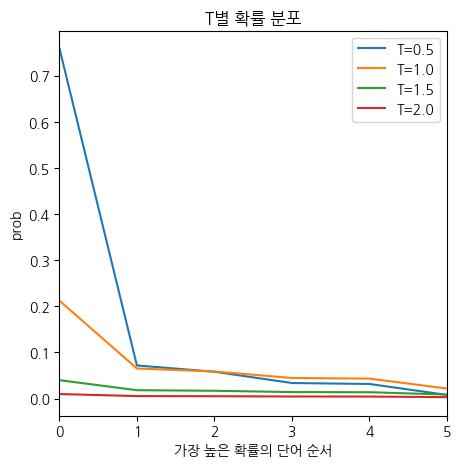

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
for t in temperatures:
    logit_softmax = softmax(logit.to("cpu"),t)
    logit_softmax_solted = logit_softmax.sort(descending=True).values
    logit_softmax_dict  = {tokenizer.decode(i):float(k) for i,k in enumerate(logit_softmax_solted)
                           if k > 0.001}
    prob_by_t = pd.DataFrame(logit_softmax_dict.items(),
                            columns=["word",f"prob"])
    
    sns.lineplot(x=prob_by_t.index,
                 y=prob_by_t["prob"], 
                 legend="auto",
                 label=f"T={t}",
                 ax=ax)
ax.set_xlabel("가장 높은 확률의 단어 순서")
ax.set_title("T별 확률 분포")
ax.set_xlim(0,5) # temperature 가 높아질수록 확률이 전체적으로 낮아지는 경향을 보임 : 낮은 확률의 중요도가 높아짐

### top K and top P(Nuclears sampling)

- 여게서 K는 갯수, P는 누적확율
- 각 타임 스텝에서 샘플링에 사용할 토큰 갯수를 줄인다.
- 총 50257개의 토큰중 확률이 매우 낮은경우를 피한다.
- 즉 상위 확률의 토큰중에서만 고르게 한다. (즉 long tail 을 잘라낸다.)

In [295]:
output_temp = model.generate(input_ids,
                             max_length=max_length,
                             do_sample=True,
                             no_repeat_ngram_size = 2,  # n_gram 단위 중복 제한 2
                             temperature = 0.5,         # 좀더 높은 확률의 단어 토큰 선택
                             top_k=50                   # 상위 50개의 토큰 까지만
                             )

print("\n\n\n",tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.





 Surfing is a popular sport in the Caribbean, and is also popular in other parts of the world. Surfers often travel to the United States to compete.

Surfers are often known for their colorful costumes and colorful wetsuits. They also have a reputation for being extremely competitive.<|endoftext|>


In [296]:
output_temp = model.generate(input_ids,
                             max_length=max_length,
                             do_sample=True,
                             no_repeat_ngram_size = 2,  # n_gram 단위 중복 제한 2
                             temperature = 0.5,         # 좀더 높은 확률의 단어 토큰 선택
                             top_p=0.9                  # long tail 자르기
                             )

print("\n\n\n",tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.





 Surfing is a great way to get around town. If you're looking for a fun way of getting around, then you've come to the right place!

The Surf City is located in the heart of the City of Angels. We have a variety of surf shops, surf schools, and surf rentals. Our surf shop has been serving the surf community in Los Angeles for over 30 years. The Surf Shop is the place to go for all of your surf gear needs.
.<|endoftext|>


In [298]:
output_temp = model.generate(input_ids,
                             max_length=max_length,
                             do_sample=True,
                             no_repeat_ngram_size = 2,  # n_gram 단위 중복 제한 2
                             temperature = 0.5,         # 좀더 높은 확률의 단어 토큰 선택
                             top_k=50,                  # 상위 토큰 50개중에
                             top_p=0.9                  # 90퍼센트까지만 이용 (tail 자르기)
                             )

print("\n\n\n",tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.





 Surfing is a great way to spend time with friends and family, but it's also a good way for people to get to know each other. Surfers can get a lot of information about each others' lives, and it can be a fun way of getting to meet new people.

Surfers are generally friendly and easy going, which makes it easy to make friends. They're also very laid back, so you can spend a few hours with them and not feel like you're bothering anyone. In fact, most people don't mind if you just hang out with a couple of surfers.<|endoftext|>
